In [ ]:
!wget https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/master/colab_setup.ipynb
%run colab_setup.ipynb

# Retrieving Result Collections

**Based on the existing example**: https://github.com/openforcefield/openff-qcsubmit/blob/main/examples/retrieving-results.ipynb

This example shows how QCSubmit can be used to retrieve the results of quantum chemical (QC) calculations from a [QCFractal] instance such as [QCArchive].

In particular, it demonstrates how:

* raw torsion drive, optimised geometry and hessian result records can be retrieved from the public
  [QCArchive] server and stored in a result collection

* the retrieved result records can be filtered and curated using a set of built-in filters

* the result collection can be saved and loaded from disk

[QCFractal]: http://docs.qcarchive.molssi.org/projects/qcfractal/en/latest/
[QCArchive]: https://qcarchive.molssi.org/

For the sake of clarity all verbose warnings will be disabled in this tutorial:

In [1]:
import warnings

warnings.filterwarnings('ignore')
import logging
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

## Retrieving result collections

QCSubmit provides a suite of utilities for retrieving and curating collections of QC results directly from a running QCFractal server, or an already computed QCPortal dataset. This functionality is provided through three main classes:

* `BasicResultCollection` - stores references to simple QCPortal result record that may contain energies, gradients, or hessians computed for a molecule in a single conformation.

* `OptimizationResultCollection` - stores references to full optimization result records (i.e. `OptimizationRecord`
  objects), as well as the final minimised conformer produced by the optimization.

* `TorsionDriveResultCollection` - stores references to full torsion drive result records (i.e. `TorsionDriveRecord`
  objects), as well as the minimum energy conformer associated with each torsion angle that was scanned.

Each of these collections can be generated directly from a running `QCFractal` server using the `from_server` class
method.

We begin by creating a QCPortal `FractalClient` instance that will allow us to communicate with the running
server. By default, `FractalClient` connects to the main QCArchive server:

In [2]:
from qcportal import FractalClient

qc_client = FractalClient()

Other servers can be accessed by providing the server's URI.

We can then use this to generate our result collections:

In [3]:
from openff.qcsubmit.results import (
    BasicResultCollection,
    OptimizationResultCollection,
    TorsionDriveResultCollection,
)

# Pull down the energy result records from the 'OpenFF BCC Refit Study COH v1.0' dataset.
#energy_result_collection = BasicResultCollection.from_server(
#    client=qc_client,
#    datasets="OpenFF BCC Refit Study COH v1.0",
#    spec_name="resp-2-vacuum"
#)
#print(energy_result_collection)

# Pull down the optimization records from both the 'OpenFF Gen 2 Opt Set 3 Pfizer Discrepancy' and
# 'OpenFF Gen 2 Opt Set 4 eMolecules Discrepancy' datasets.
#optimization_result_collection = OptimizationResultCollection.from_server(
#    client=qc_client,
#    datasets=[
#        "OpenFF Gen 2 Opt Set 3 Pfizer Discrepancy",
#        "OpenFF Gen 2 Opt Set 4 eMolecules Discrepancy",
#    ],
#    spec_name="default",
#)
#print(optimization_result_collection)

# Pull down the torsion drive records from the 'OpenFF Rowley Biaryl v1.0' dataset.
torsion_drive_result_collection = TorsionDriveResultCollection.from_server(
    client=qc_client,
    #datasets="OpenFF Rowley Biaryl v1.0",
    #datasets="OpenFF Protein Capped 3-mer Omega v1.0",
    datasets="OpenFF Protein Capped 3-mer Backbones v1.0",
    
    spec_name="default",
)
print(torsion_drive_result_collection)

entries={'https://api.qcarchive.molssi.org:443/': [TorsionDriveResult(type='torsion', record_id='104348495', cmiles='[H:29][C@@:24]([C:25](=[O:26])[N:33]([H:40])[C@:34]([H:41])([C:35](=[O:36])[N:49]([H:51])[C:50]([H:52])([H:53])[H:54])[C:37]([H:42])([C:38]([H:43])([H:44])[H:45])[C:39]([H:46])([H:47])[H:48])([C:27]([H:30])([H:31])[H:32])[N:23]([H:28])[C:9](=[O:10])[C@:8]([H:15])([C:11]([H:16])([C:12]([H:17])([H:18])[H:19])[C:13]([H:20])([H:21])[H:22])[N:7]([H:14])[C:1](=[O:2])[C:3]([H:4])([H:5])[H:6]', inchi_key='JHBKYDIWHUGPSD-NQRAZRSKNA-N'), TorsionDriveResult(type='torsion', record_id='104348544', cmiles='[H:13][C@@:8]([C:9](=[O:10])[N:17]([H:25])[C@:18]([H:26])([C:19](=[O:20])[N:30]([H:35])[C@:31]([H:36])([C:32](=[O:33])[N:40]([H:42])[C:41]([H:43])([H:44])[H:45])[C:34]([H:37])([H:38])[H:39])[C:21]([H:27])([H:28])[C:22](=[O:23])[O:24][H:29])([C:11]([H:14])([H:15])[H:16])[N:7]([H:12])[C:1](=[O:2])[C:3]([H:4])([H:5])[H:6]', inchi_key='DFRSMLTYXUADOY-WMXHRXQGNA-N'), TorsionDriveResult(t

*Note: currently only complete results are pulled down by the `from_server` method*

There are two main inputs to the `from_server` method, in addition to the fractal client:

* the name(s) of the existing datasets to retrieve the results of. This can either be the name of a single dataset or a list of dataset names
* the name of the specification used to compute the records. Each specification corresponds to a particular basis, method, program and additional settings.

Let's print out some basic information about each of these result collections:

In [4]:
print("===TORSION DRIVE RESULTS===")

print(f"N RESULTS:   {torsion_drive_result_collection.n_results}")
print(f"N MOLECULES: {torsion_drive_result_collection.n_molecules}")

===TORSION DRIVE RESULTS===
N RESULTS:   23
N MOLECULES: 23


This allows results generated by multiple different servers (e.g. a local fractal instance and the public QCArchive
server) to be stored in a single result collection object.

The references to the actual data are then stored in corresponding lists:

In [5]:
torsion_drive_result_collection.entries[qc_client.address][:10]

[TorsionDriveResult(type='torsion', record_id='104348495', cmiles='[H:29][C@@:24]([C:25](=[O:26])[N:33]([H:40])[C@:34]([H:41])([C:35](=[O:36])[N:49]([H:51])[C:50]([H:52])([H:53])[H:54])[C:37]([H:42])([C:38]([H:43])([H:44])[H:45])[C:39]([H:46])([H:47])[H:48])([C:27]([H:30])([H:31])[H:32])[N:23]([H:28])[C:9](=[O:10])[C@:8]([H:15])([C:11]([H:16])([C:12]([H:17])([H:18])[H:19])[C:13]([H:20])([H:21])[H:22])[N:7]([H:14])[C:1](=[O:2])[C:3]([H:4])([H:5])[H:6]', inchi_key='JHBKYDIWHUGPSD-NQRAZRSKNA-N'),
 TorsionDriveResult(type='torsion', record_id='104348544', cmiles='[H:13][C@@:8]([C:9](=[O:10])[N:17]([H:25])[C@:18]([H:26])([C:19](=[O:20])[N:30]([H:35])[C@:31]([H:36])([C:32](=[O:33])[N:40]([H:42])[C:41]([H:43])([H:44])[H:45])[C:34]([H:37])([H:38])[H:39])[C:21]([H:27])([H:28])[C:22](=[O:23])[O:24][H:29])([C:11]([H:14])([H:15])[H:16])[N:7]([H:12])[C:1](=[O:2])[C:3]([H:4])([H:5])[H:6]', inchi_key='DFRSMLTYXUADOY-WMXHRXQGNA-N'),
 TorsionDriveResult(type='torsion', record_id='104348578', cmiles='[H

After running the above command, notice that the entries stored in the collection are not the actual result
records generated and stored on the server, but rather a reference to them. In particular, the unique ID of the record is stored along with a SMILES depiction of the molecule the result was generated for.

The main reason for doing this is that we often would like to be able to state which data we would like to use in
an application without having to create multiple copies of the data. Not only can this take up large amounts of disk space, it runs the risk of data becoming out of sync with the original if the format the records are stored in changes or the local copy of the data is accidentally mutated. Storing a reference to the original data and then retrieving it when needed is typically a cleaner and safer solution.

## Retrieving the result records

The raw result record objects can be easily retrieved using the result collection objects:

In [6]:
torsion_drive_records = torsion_drive_result_collection.to_records()
torsion_drive_records[:5]

[(TorsionDriveRecord(id='104348495', status='COMPLETE'),
  Molecule with name '' and SMILES '[H][C@@](C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])N([H])C(=O)[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])N([H])C(=O)C([H])([H])[H]'),
 (TorsionDriveRecord(id='104348544', status='COMPLETE'),
  Molecule with name '' and SMILES '[H][C@@](C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C([H])([H])[H])C([H])([H])C(=O)O[H])(C([H])([H])[H])N([H])C(=O)C([H])([H])[H]'),
 (TorsionDriveRecord(id='104348578', status='COMPLETE'),
  Molecule with name '' and SMILES '[H][C@@](C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])C(=O)O[H])N([H])C(=O)[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])N([H])C(=O)C([H])([H])[H]'),
 (TorsionDriveRecord(id='104348638', status='COMPLETE'),
  Molecule with name '' and SMILES '[H][C@@](C(=O)N([H])[C@]([H])(C(=O)N([H])[C@]([H])(C(=O)N([H])C([H])([H]

QCSubmit seamlessly takes care of pulling the data from the server in the most efficient way making sure to take
advantage of the pagination that QCFractal provides. Further, it attempts to cache all calls to the server so that
multiple calls to `to_records` does not need to constantly query the server.

Notice that not only are the raw result records retrieved, but also an OpenFF `Molecule` object is created for each result record. This molecule has the correct ordering and also stores any conformers associated with the
result collection. For basic collections, the conformer is the one that was used in any calculations; for optimization collections, it is the final conformer yielded by the optimization; and for torsion drives, it is the lowest energy conformer for each sampled torsion angle.

In the case of torsion drive records, we can easily iterate over the grid ID, the associated conformer, and the
associated energy in one go:

In [31]:
torsion_drive_record, molecule = torsion_drive_records[0]
from matplotlib import pyplot
import numpy as np
from openff.units import unit
energy_grid = np.zeros((24,24))
for grid_id, qc_conformer in zip(
    molecule.properties["grid_ids"], molecule.conformers
):

    qc_energy = torsion_drive_record.final_energy_dict[grid_id]
    
    grid_tuple = [int(i) for i in grid_id.strip("[]").split(',')]
    phi_bin = (grid_tuple[0]+165) / 15
    psi_bin = (grid_tuple[1]+165) / 15
    #print(phi_bin, psi_bin)
    #qc_energy_kcal_per_mol = (qc_energy * unit.hartree).to(unit.kilo)
    energy_grid[int(psi_bin), int(phi_bin)] = qc_energy
    print(f"{grid_id} E={qc_energy:.4f} Ha")

[-165, -165] E=-1148.0092 Ha
[-165, -150] E=-1148.0089 Ha
[-165, -135] E=-1148.0090 Ha
[-165, -120] E=-1148.0085 Ha
[-165, -105] E=-1148.0077 Ha
[-165, -90] E=-1148.0072 Ha
[-165, -75] E=-1148.0075 Ha
[-165, -60] E=-1148.0087 Ha
[-165, -45] E=-1148.0091 Ha
[-165, -30] E=-1148.0088 Ha
[-165, -15] E=-1148.0103 Ha
[-165, 0] E=-1148.0117 Ha
[-165, 15] E=-1148.0125 Ha
[-165, 30] E=-1148.0123 Ha
[-165, 45] E=-1148.0113 Ha
[-165, 60] E=-1148.0100 Ha
[-165, 75] E=-1148.0091 Ha
[-165, 90] E=-1148.0089 Ha
[-165, 105] E=-1148.0092 Ha
[-165, 120] E=-1148.0099 Ha
[-165, 135] E=-1148.0106 Ha
[-165, 150] E=-1148.0111 Ha
[-165, 165] E=-1148.0109 Ha
[-165, 180] E=-1148.0101 Ha
[-150, -165] E=-1148.0087 Ha
[-150, -150] E=-1148.0080 Ha
[-150, -135] E=-1148.0081 Ha
[-150, -120] E=-1148.0079 Ha
[-150, -105] E=-1148.0072 Ha
[-150, -90] E=-1148.0068 Ha
[-150, -75] E=-1148.0073 Ha
[-150, -60] E=-1148.0078 Ha
[-150, -45] E=-1148.0081 Ha
[-150, -30] E=-1148.0096 Ha
[-150, -15] E=-1148.0115 Ha
[-150, 0] E=-1148.

Text(0.5, 0, 'psi')

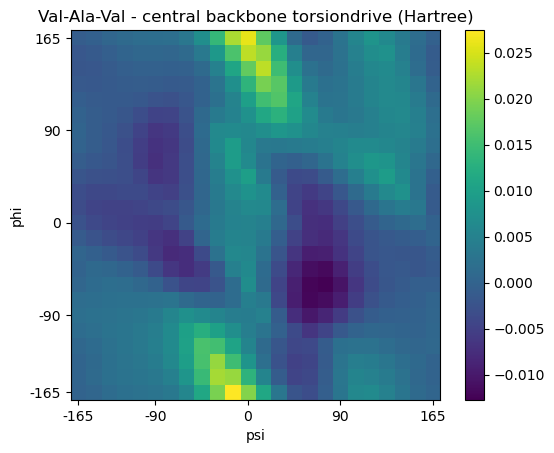

In [34]:
energy_grid -= energy_grid[0,0]
pyplot.imshow(energy_grid, origin="lower")
pyplot.title("Val-Ala-Val - central backbone torsiondrive (Hartree)")
pyplot.colorbar()
pyplot.yticks([0, 5, 11, 17, 23], [-165, -90, 0, 90, 165])
pyplot.xticks([0, 5, 11, 17, 23], [-165, -90, 0, 90, 165])
pyplot.ylabel("phi")
pyplot.xlabel("psi")

In [8]:
molecule.visualize("nglview")

NGLWidget(max_frame=575)